# Chapter 14 - Numerical modelling of two-phase flow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import warnings 
warnings.filterwarnings('ignore')

## The 1-D solitary wave (instantaneous)

The compaction equation reads

$$
\begin{equation}
  \label{eq:num-cmp-eqn}
  \diff{}{z}\npor^\permexp\diff{\cmp}{z} - \cmp = \diff{\npor^\permexp}{z}.
\end{equation}
$$

### Finite Difference Discretisation

The finite-difference form of equation $\eqref{eq:num-cmp-eqn}$ is

$$
\begin{equation}
  \label{eq:num-cmpeqn-stencil}
  \left[\begin{array}{ccc}
      \npor^\permexp_{i-1/2}, & -\left(\Dz^2+\npor^\permexp_{i-1/2}+
                               \npor^\permexp_{i+1/2}\right), & \npor^\permexp_{i+1/2}
    \end{array} \right]\aprx{\cmp}_i = \Dz\left(\npor_{i+1/2}^\permexp -
    \npor_{i-1/2}^\permexp\right).
\end{equation}
$$

**NOTE**: In stencil notation, multiplication of a stencil $\left[S_a,\;\;S_b,\;\;S_c\right]$ with a discrete variable $q_i$ is computed as $S_aq_{i-1} + S_bq_{i} + S_cq_{i+1}$}.

To make progress toward solving for $\aprx{\cmp}_i$, we write $\eqref{eq:num-cmpeqn-stencil}$ in the form $\mathbf{A}\posvec = \boldsymbol{b}$, where $\boldsymbol{b}$ is a column vector with $b_i=\Dz\left(\npor_{i+1/2}^\permexp - \npor_{i-1/2}^\permexp\right)$. The unknowns go into column vector $\posvec$. The stencil is used to fill a tridiagonal band in the matrix $\mathbf{A}$. The first and last rows in  $\mathbf{A}$ and $\boldsymbol{b}$ are constructed to satisfy the boundary conditions. The result is

$$
\begin{equation}
  \label{eq:num-fd-matrix-equation}
  \left(\begin{array}{cccccc}
          1 & 0 & & & &  \\[1mm]
          [\,\, & S_2 & \,\,] & & &  \\[1mm]
            & [\,\, & S_3 & \,\,] &  &  \\[1mm]
            & & & \ddots & & \\[1mm]
            & &  & [\,\, & S_{N_z-1}& \,\,] \\[1mm]
            & & & & 0 & 1 \end{array}\right)
        \left(\begin{array}{c}\aprx{\cmp}_1 \\[1mm] \aprx{\cmp}_2 \\[1mm] 
                \aprx{\cmp}_3 \\[1mm] \vdots \\[1mm] \aprx{\cmp}_{N_z-1} \\[1mm] 
                \aprx{\cmp}_{N_z}\end{array}\right) = 
            \left(\begin{array}{c} 0 \\[1mm] 
                 b_2 \\[1mm] b_3 \\[1mm]  \vdots \\[1mm] 
                 b_{N_z-1} \\[1mm] 0\end{array}\right),
\end{equation}
$$

where $[\;\;S_i\;\;]$ is the $i^\text{th}$ stencil, given in equation $\eqref{eq:num-cmpeqn-stencil}$ above.

The Python function below solves the system $\mathbf{A}\posvec = \boldsymbol{b}$:

In [2]:
def SolveCompactionRateFiniteDifference(phi, dz):

    # matrix size
    n_ = len(phi)

    # form permeability
    K = np.power(0.5*(phi[0:-1] + phi[1:]), par.n)

    # form RHS
    b = np.zeros(n_, dtype=float)
    b[1:-1] = dz*(K[1:] - K[0:-1])
    
    # create sparse matrix
    offsets = np.array([0, -1, 1])
    data = np.zeros(3 * n_).reshape(3, n_)
    data[0, 0] = data[0, -1] = 1
    data[0, 1:-1] = -(dz*dz + K[0:-1] + K[1:])  # diagonal
    data[1, 0:-2] = K[0:-1]  # sub-diagonal
    data[2, 2:] = K[1:]  # sup-diagonal
    mtx = sp.dia_matrix((data, offsets), shape=(n_, n_))
    mtx = mtx.tocsr()
    x = spla.dsolve.spsolve(mtx, b)
    
    return x

### Finite Element Discretisation

The Finite Element form of equation \eqref{eq:num-cmp-eqn} is

$$
\begin{equation}
  \label{eq:num-solwave-discrete-elementwise}
  \sum_{i=1}^{N_z}c_i\int_{\Omega_e} \left(K\basis_e^\prime\basis_i^\prime +
    \basis_e\basis_i\right)\infd\Omega = 
  \int_{\Omega_e} K\basis_e^\prime\infd\Omega.
\end{equation}
$$

Equation $\eqref{eq:num-solwave-discrete-elementwise}$ can be expressed in terms of a matrix-vector product $\mathbf{A}\boldsymbol{x} = \boldsymbol{b}$, where 

$$
\begin{align*}
    \mathbf{A} &= \sum_e \int_{\Omega_e} \left(K\basis_e^\prime\basis_i^\prime +
    \basis_e\basis_i\right)\infd\Omega \\
    \boldsymbol{b} &= \sum_e \int_{\Omega_e} K\basis_e^\prime\infd\Omega,
\end{align*}
$$

and the vector of unknowns $\boldsymbol{x}$ represents the coefficients $c_i$.  In the equation above, $\sum_e$ is the assembly operator. To clarify the assembly operation, we write the bilinear and linear forms evaluated over one element $\Omega_j$, which is written as the sub-matrix and sub-vector

$$
\begin{align}
    \mathbf{A}^{\Omega_e} &= \int_{\Omega_e} 
      \left(\begin{array}{cc}
        K\basis_j^\prime\basis_j^\prime + \basis_j\basis_j
        & K\basis_j^\prime\basis_{j+1}^\prime + \basis_j\basis_{j+1} \\
        K\basis_{j+1}^\prime\basis_j^\prime + \basis_{j+1}\basis_j
        & K\basis_{j+1}^\prime\basis_{j+1}^\prime + \basis_{j+1}\basis_{j+1}
      \end{array}\right)\infd\Omega,\\
    \label{eq:num-solwave-linear-form-subvec}
    \boldsymbol{b}^{\Omega_e} &=  \int_{\Omega_e} \left(\begin{array}{c}
      K\basis_{j}^\prime \\
      K\basis_{j+1}^\prime
     \end{array}\right)\infd\Omega.
\end{align}
$$

Then the assembly of the global matrix $\mathbf{A}$ and global vector $\boldsymbol{b}$ involve summing the entries of $\mathbf{A}^{\Omega_e}$ and $\boldsymbol{b}^{\Omega_e}$ into the correct locations (recalling that $\mathbf{A}$ is symmetrical).

The Python function below solves the system $\mathbf{A}\boldsymbol{x} = \boldsymbol{b}$:

In [3]:
def SolveCompactionRateFiniteElement(phi, dz):

    # number of nodes
    N = len(phi)

    # number of elements
    N_elements = N - 1  
    
    # allocate memory
    A = sp.dok_matrix((N, N), dtype=np.double)
    
    # allocate memory
    b = np.zeros(N, dtype=np.double)

    # loop over elements
    for e in range(N_elements):
        A[e:e+2, e:e+2] = 0.  # initializing matrix

    Me = sp.dok_matrix([[1./dz, -1./dz], [-1.0/dz, 1./dz]], dtype=np.double)
    Ce = sp.dok_matrix([[dz/3., dz/6.], [dz/6., dz/3.]], dtype=np.double)
    re = np.asarray([-1.0, 1.0], dtype=np.double)

    # form permeability at element centres
    K = np.power(0.5 * (phi[0:-1] + phi[1:]), par.n)

    # loop over elements
    for e in range(N_elements):
        # element bilinear form
        Ae = Me * K[e] + Ce
        be = re * K[e]         # element linear form
        A[e:e+2, e:e+2] += Ae  # assemble global matrix
        b[e:e+2] += be         # assemble global RHS

    A[[0, -1], [0, -1]] = 1.0
    A[[0, -1], [1, -2]] = 0.0  # zero boundary rows
    b[0] = b[-1] = 0           # boundary condition
    A = A.tocsr()

    # solve
    x = spla.dsolve.spsolve(A, b)

    return x

The analytical solution of the compact equation $\eqref{eq:num-cmp-eqn}$ is given by

In [4]:
def xi(f, A):

    return -np.sqrt(A + 0.5) * (
        -2. * np.sqrt(A - f) + np.log(
            (
                np.sqrt(A - 1.)-np.sqrt(A - f)
            ) / (
                np.sqrt(A - 1.)+np.sqrt(A - f)
            )
        ) / np.sqrt(A - 1.)
    )

def SolitaryWaveGenerator(Amplitude, z, z0):

    f = np.ones(z.shape[0])
    zeta = np.abs(z-z0)
    fEpsilon = 1.000000001
    zetaEpsilon = xi(fEpsilon, Amplitude)
    ifill = np.nonzero(zeta <= zetaEpsilon)

    for i in ifill[0]:
        f[i] = brentq(
            lambda phi_: xi(phi_, Amplitude)-zeta[i], 
            fEpsilon, 
            Amplitude
        )
    
    return f

Figure 14.2 below plots the error $\error$ versus number of nodes $N_z$ for numerical solutions of the Compaction Equation $\eqref{eq:num-cmp-eqn}$. The solid line marks the error for the finite difference method $\eqref{eq:num-cmpeqn-stencil}$. The dashed line marks the error for the finite element method. The analytical solution is shown in chapter 6.

In [5]:
class PAR:

    def __init__(
        self, n=3, ls=4, zm=40, 
        ni=np.power(
            2., [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
        )
    ):

        self.n = n
        self.Ls = ls
        self.V = 2*self.Ls + 1
        self.zm = zm
        self.ni = ni

In [6]:
par = PAR()
err_fd = np.zeros(len(par.ni))
err_fe = np.zeros(len(par.ni))

for n, ni in enumerate(par.ni):

    z = np.linspace(-par.zm, par.zm, int(ni))

    # semi-analytical solitary wave profile
    phi = SolitaryWaveGenerator(par.Ls, z, 0)

    # analytical compaction rate
    a_cmp = np.sign(z) * np.sqrt(
        -2. * par.V * (phi-1)**2 / phi**2 * (phi - (par.V-1.)/2.)
    )

    # numerical compaction rate
    n_cmp_fd = SolveCompactionRateFiniteDifference(phi, z[1]-z[0])
    n_cmp_fe = SolveCompactionRateFiniteElement(phi, z[1]-z[0])

    # error
    err_fd[n] = np.linalg.norm(a_cmp-n_cmp_fd, 2) / np.linalg.norm(a_cmp, 2)
    err_fe[n] = np.linalg.norm(a_cmp-n_cmp_fe, 2) / np.linalg.norm(a_cmp, 2)

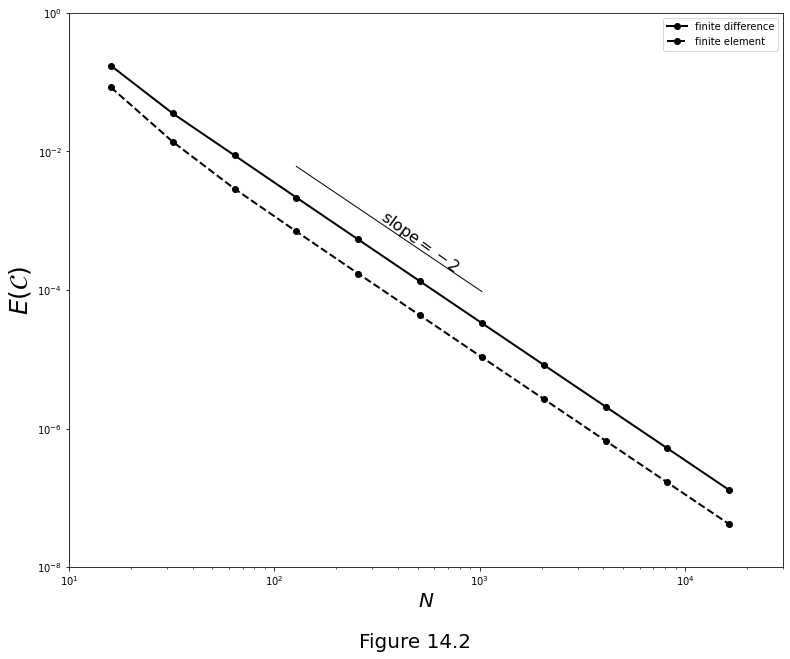

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(9., 9.)

# plotting
p1, = plt.loglog(par.ni, err_fd, '-ok', linewidth=2)
p2, = plt.loglog(par.ni, err_fe, '--ok', linewidth=2)
plt.loglog(
    par.ni[3:7], 100*np.power(par.ni[3:7], -2), '-k', linewidth=1
)
plt.xlabel(r'$N$', fontsize=20)
plt.ylabel(r'$E(\mathcal{C})$', fontsize=25)
plt.text(
    par.ni[5], 190*np.power(par.ni[6], -2), r'slope$=-2$', 
    fontsize=16, rotation=-36, horizontalalignment='center'
)
plt.xlim(10.0, 3.e4)
plt.ylim(1.e-8, 1.0)
plt.tick_params(axis='both', which='major', labelsize=13)
leg = plt.legend(
    handles=[p1, p2], labels=['finite difference', 'finite element']
)

fig.supxlabel("Figure 14.2", fontsize=20)

plt.show()

## A 2-D manufactured solution (instantaneous)

We seek numerical solutions to the instantaneous flow problem for a given, two-dimensional porosity field

$$
\begin{align}
    \label{eq:num_mfcsol_gov_compaction}
    -\Div\vel\sol + \Div\left[\mobility \left(\Grad\pres + \yhat\right)\right] &= \cmpforce, \\
    \label{eq:num_mfcsol_gov_stokes}
    -\Grad\pres + \delta^2\delsq\vel\sol + 2\delta^2\Grad\left(\Div\vel\sol\right)
    - \por\yhat &= \stokesforce.
\end{align}
$$

where all symbols are now dimensionless; $\mobility = \left(\por/\por_0\right)^\permexp$ is the mobility, $\yhat = \gravity/g$ is the direction of gravitational acceleration, and $\delta = \cmplength_0/H$ is a non-dimensional compaction length ($\cmplength_0$ is the reference, dimensional compaction length). $\cmpforce$ and $\stokesforce$ are obtained by substituting analytical functions $\vel\sol_\manufac$ and $\pres_\manufac$ (the *manufactured solution*) into the augmented governing equations $\eqref{eq:num_mfcsol_gov_compaction}$-$\eqref{eq:num_mfcsol_gov_stokes}$.

A reasonable choice (among many) is

$$
\begin{align}
    \label{eq:num-manufac-solution1}
    \phi_\manufac &= \phi_0\left[1 + \phi^*\cos\left(m\pi x\right)\cos\left(m\pi y\right)\right],\\
    \label{eq:num-manufac-solution2}
    \pres_\manufac &= P^*\cos\left(m\pi x\right)\cos\left(m\pi y\right),\\
    \label{eq:num-manufac-solution3}
    \psi_\manufac &= -\psi^*\left[1 - \cos\left(m\pi x\right)\right]\left[1 - \cos\left(m\pi y\right)\right],\\
    \label{eq:num-manufac-solution4}
    \scalarpotential_\manufac &= \scalarpotential^* \cos\left(m\pi x\right)\cos\left(m\pi y\right),
\end{align}
$$

These functions are implemented in Python below:

In [8]:
def MnfcSoln_phi(X, Y, par):

    return par.phi0 * (
        1.0 
        + par.A_phi * np.cos(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)
    )


def MnfcSoln_psi(X, Y, par):

    return par.A_psi * (
        1.0 - np.cos(np.pi * par.m * X)
    ) * (
        1.0 - np.cos(np.pi * par.m * Y)
    )


def MnfcSoln_U(X, Y, par):

    return par.A_U * \
        np.sin(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)


def MnfcSoln_P(X, Y, par):

    return par.A_ * \
        np.sin(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)


def MnfcSoln_CurlPsi(X, Y, par):

    Cpsi_x = par.A_psi * (
        1.0 - np.cos(np.pi * par.m * X)
    ) * (
        np.pi * par.m * np.sin(np.pi * par.m * Y)
    )
    Cpsi_y = -par.A_psi * (
        np.pi * par.m * np.sin(np.pi * par.m * X)
    ) * (
        1.0 - np.cos(np.pi * par.m * Y)
    )

    return Cpsi_x, Cpsi_y


def MnfcSoln_GradU(X, Y, par):

    GU_x = par.A_U * \
        np.pi * par.m * np.cos(np.pi * par.m * X) * \
        np.sin(np.pi * par.m * Y)
    GU_y = par.A_U * \
        np.pi * par.m * np.sin(np.pi * par.m * X) * \
        np.cos(np.pi * par.m * Y)

    return GU_x, GU_y


def MnfcSoln_DelsqU(X, Y, par):

    return -2.0 * np.pi**2 * par.m**2 * MnfcSoln_U(X, Y, par)


def MnfcSoln_GradDelsqU(X, Y, par):

    GdelsqU_x, GdelsqU_y = MnfcSoln_GradU(X, Y, par)
    GdelsqU_x = -2.0*np.pi**2 * par.m**2 * GdelsqU_x
    GdelsqU_y = -2.0*np.pi**2 * par.m**2 * GdelsqU_y

    return GdelsqU_x, GdelsqU_y


def MnfcSoln_GradP(X, Y, par):

    GP_x = par.A_P * np.pi * par.m * \
        np.cos(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)
    GP_y = par.A_P * np.pi * par.m * \
        np.sin(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)

    return GP_x, GP_y


def MnfcSoln_VelS(X, Y, par):

    Vx, Vy = MnfcSoln_CurlPsi(X, Y, par)
    Vxc, Vyc = MnfcSoln_GradU(X, Y, par)

    return Vx + Vxc, Vy + Vyc

In [9]:
class PAR:

    def __init__(
        self, m=2, n=3, phi0=0.01, delta=1, 
        a_psi=1.0, a_u=1.0, a_p=1.0, a_phi=0.1
    ):

        self.m = m
        self.n = n
        self.phi0 = phi0
        self.delta = delta
        # amplitudes
        self.A_psi = a_psi
        self.A_U = a_u
        self.A_P = a_p
        self.A_phi = a_phi

Figure 14.4 below plots the manufactured solution, computed using equations $\eqref{eq:num-manufac-solution1}$-$\eqref{eq:num-manufac-solution4}$, for $m=2$, $\psi^*=\scalarpotential^*=1$, and $\phi^*=0.1$. All quantities are dimensionless. The pressure $\pres_\manufac$ is not shown. __(a)__ The shear potential $\psi_\manufac$ is shown in grayscale; vectors illustrate $\Curl\psi_\manufac\zhat$, the incompressible part of the flow. __(b)__ The compaction potential $\scalarpotential_\manufac$ is shown in grayscale; vectors illustrate $\Grad\scalarpotential_\manufac$, the compaction part of the flow. __(c)__ The porosity $\phi_\manufac$ is shown in grayscale; vectors illustrate the total solid flow field $\vel\sol_\manufac$.

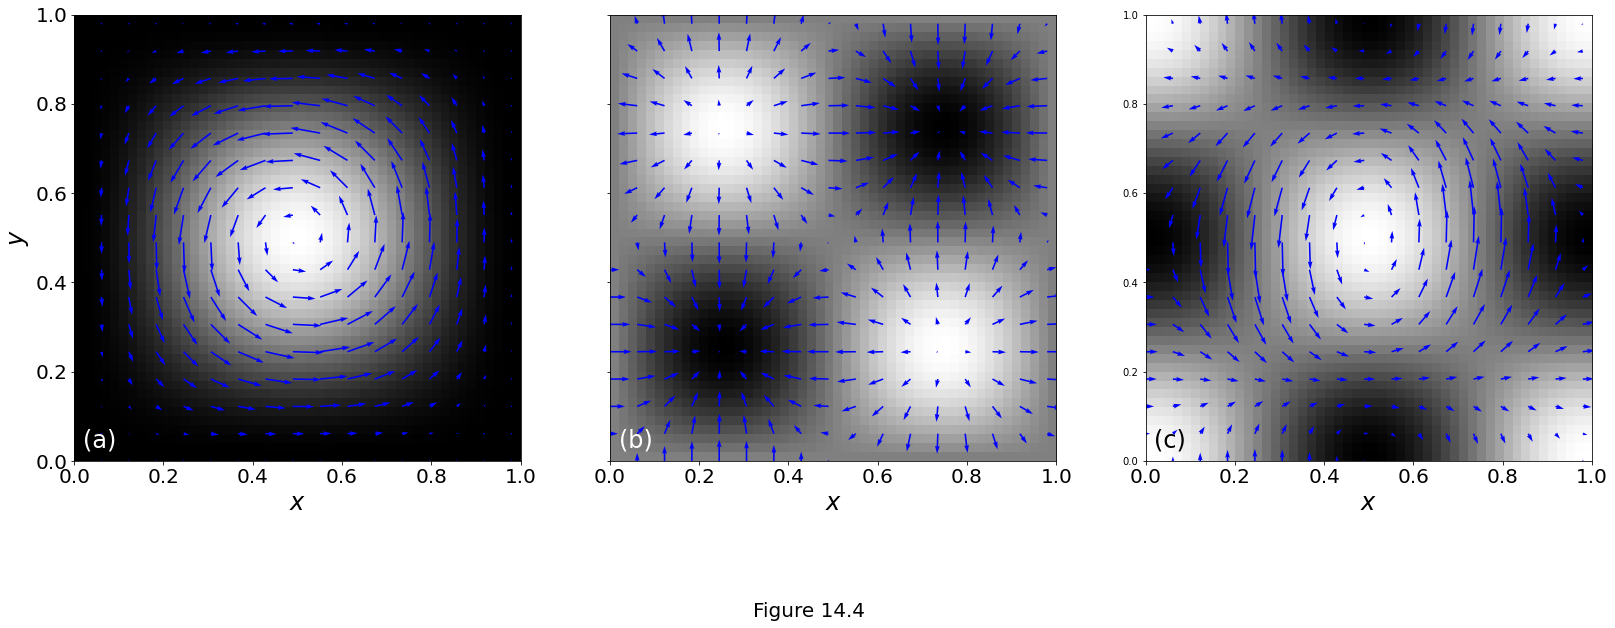

In [10]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12., 6.)

par = PAR()

N = 50
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
ss = 3

psi = MnfcSoln_psi(X, Y, par)  # shear potential
ax[0].imshow(psi, cmap=plt.cm.gray, extent=[0, 1, 0, 1])
Vx, Vy = MnfcSoln_CurlPsi(X, Y, par)
ax[0].quiver(
    X[0::ss, 0::ss], Y[0::ss, 0::ss], 
    Vx[0::ss, 0::ss], Vy[0::ss, 0::ss], color='b'
)
ax[0].set_xlabel('$x$', fontsize=24)
ax[0].set_xticklabels(
    (0.0, 0.2, 0.4, 0.6, 0.8, 1.0), fontsize=20
)
ax[0].set_ylabel('$y$', fontsize=24)
ax[0].set_yticklabels(
    (0.0, 0.2, 0.4, 0.6, 0.8, 1.0), fontsize=20
)
ax[0].text(
    0.02, 0.02, r'(a)', fontsize=24, 
    verticalalignment='bottom', horizontalalignment='left', 
    color='white'
)
ax[0].tick_params(axis='both', which='major', labelsize=13)

U = MnfcSoln_U(X, Y, par)
Vx, Vy = MnfcSoln_GradU(X, Y, par)
ax[1].imshow(U, cmap=plt.cm.gray, extent=[0, 1, 0, 1])
ax[1].quiver(
    X[0::ss, 0::ss], Y[0::ss, 0::ss], 
    Vx[0::ss, 0::ss], Vy[0::ss, 0::ss], color='b'
)
ax[1].set_xlabel('$x$', fontsize=24)
ax[1].set_xticklabels(
    (0.0, 0.2, 0.4, 0.6, 0.8, 1.0), fontsize=20
)
ax[1].set_yticklabels(())
ax[1].text(
    0.02, 0.02, r'(b)', fontsize=24, 
    verticalalignment='bottom', horizontalalignment='left', 
    color='white'
)
ax[1].tick_params(axis='both', which='major', labelsize=13)

phi = MnfcSoln_phi(X, Y, par)
Vx, Vy = MnfcSoln_VelS(X, Y, par)
ax[2].imshow(phi, cmap=plt.cm.gray, extent=[0, 1, 0, 1])
ax[2].quiver(
    X[0::ss, 0::ss], Y[0::ss, 0::ss], 
    Vx[0::ss, 0::ss], Vy[0::ss, 0::ss], color='b'
)
ax[2].text(
    0.02, 0.02, '(c)', fontsize=24, 
    verticalalignment='bottom', horizontalalignment='left'
)
ax[2].set_xlabel('$x$', fontsize=24)
ax[2].set_xticklabels((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=13)

fig.supxlabel("Figure 14.4", fontsize=20)

plt.show()

### Finite difference discretisation

In [11]:
class PAR:

    def __init__(
        self, m=2, n=3, phi0=0.01, delta=1, 
        a_psi=1.0, a_u=1.0, a_p=1.0,
        a_phi=0.1, ni=(7, 12, 22, 42, 82)
    ):

        # physics parameters
        self.n = n
        self.phi0 = phi0
        self.delta = delta
        # manufactured solution parameters
        self.m = m
        self.A_psi = a_psi
        self.A_U = a_u
        self.A_P = a_p
        self.A_phi = a_phi
        self.ni = ni


def MnfcSoln_F(X, Y, par):

    return - MnfcSoln_DelsqU(X, Y, par) + \
        MnfcSoln_DivKGradP(X, Y, par)


def MnfcSoln_DivKGradP(X, Y, par):

    phi = MnfcSoln_phi(X, Y, par)
    K = np.power(phi/par.phi0, par.n)
    Kx = par.n / np.power(par.phi0, par.n) * (
        np.power(phi, par.n-1)
    ) * MnfcSoln_GradPhi(X, Y, 1, par)
    Ky = par.n / np.power(par.phi0, par.n) * (
        np.power(phi, par.n-1)
    ) * MnfcSoln_GradPhi(X, Y, 2, par)

    return Kx * MnfcSoln_GradP(X, Y, 1, par) + \
        Ky * (MnfcSoln_GradP(X, Y, 2, par) + 1) + \
        K * MnfcSoln_DelsqP(X, Y, par)


def MnfcSoln_DelsqP(X, Y, par):

    return -2.0 * np.pi**2 * par.m**2 * MnfcSoln_P(X, Y, par)


def MnfcSoln_GradPhi(X, Y, dir, par):

    if dir == 1:
        return -par.phi0 * np.pi * par.m * par.A_phi * \
            np.sin(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)
    else:
        return -par.phi0 * np.pi * par.m * par.A_phi * \
            np.cos(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)


def MnfcSoln_DelsqU(X, Y, par):

    return -2.0 * np.pi**2 * par.m**2 * MnfcSoln_U(X, Y, par)


def MnfcSoln_G(X, Y, dir, par):

    coeff = MnfcSoln_phi(X, Y, par) if dir == 2 else 0.0

    return - MnfcSoln_GradP(X, Y, dir, par) \
        + par.delta**2 * MnfcSoln_CurlDelsqPsi(X, Y, dir, par) \
        + 3.0 * par.delta**2 * MnfcSoln_GradDelsqU(X, Y, dir, par) \
        - coeff


def MnfcSoln_CurlDelsqPsi(X, Y, dir, par):

    if dir == 1:
        return par.A_psi * np.pi**3 * par.m**3 * (
            np.cos(np.pi * par.m * X) * np.sin(np.pi * par.m * Y) - (
                1.0 - np.cos(np.pi * par.m * X)
            ) * np.sin(np.pi * par.m * Y)
        )
    else:
        return -par.A_psi * np.pi**3 * par.m**3 * (
            np.cos(np.pi * par.m * Y) * np.sin(np.pi * par.m * X) - (
                1.0 - np.cos(np.pi * par.m * Y)
            ) * np.sin(np.pi * par.m * X)
        )


def MnfcSoln_phi(X, Y, par):

    return par.phi0 * (
        1.0 
        + par.A_phi * np.cos(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)
    )


def MnfcSoln_V(X, Y, dir, par):

    return MnfcSoln_CurlPsi(X, Y, dir, par) + MnfcSoln_GradU(X, Y, dir, par)


def MnfcSoln_U(X, Y, par):

    return par.A_U * np.sin(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)


def MnfcSoln_P(X, Y, par):

    return par.A_P * np.sin(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)


def MnfcSoln_GradP(X, Y, dir, par):

    if dir == 1:
        return par.A_P * np.pi * par.m * \
            np.cos(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)
    else:
        return par.A_P * np.pi * par.m * \
            np.sin(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)


def MnfcSoln_CurlPsi(X, Y, dir, par):

    if dir == 1:
        return par.A_psi * (
            1.0 - np.cos(np.pi * par.m * X)
        ) * (
            np.pi * par.m * np.sin(np.pi * par.m * Y)
        )
    else:
        return -par.A_psi * (
            np.pi * par.m * np.sin(np.pi * par.m * X)
        ) * (
            1.0 - np.cos(np.pi * par.m * Y)
        )


def MnfcSoln_GradDelsqU(X, Y, dir, par):

    return -2 * np.pi**2 * par.m**2 * MnfcSoln_GradU(X, Y, dir, par)


def MnfcSoln_GradU(X, Y, dir, par):

    if dir == 1:
        return par.A_U * np.pi * par.m * \
            np.cos(np.pi * par.m * X) * np.sin(np.pi * par.m * Y)
    else:
        return par.A_U * np.pi * par.m * \
            np.sin(np.pi * par.m * X) * np.cos(np.pi * par.m * Y)


In [12]:
def AssembleMatrixAndRHS(phi, dx, par):

    Nj, Ni = phi.shape
    N = Ni*Nj
    n = lambda i, j: i + j*Ni
    # node position
    X, Y = np.meshgrid(
        dx * (np.arange(0, ni)-1), 
        dx * (np.arange(0, ni)-1)
    )
    e = np.ones(N)

    # stokes equation, x - direction
    APx_stk = (-1. * sp.eye(N, k=-1) + sp.eye(N, k=0))/dx  # dP / dx
    # delsq(u)
    Axu_stk = (
        sp.eye(N, k=-Ni) + sp.eye(N, k=-1) - 4.0*sp.eye(N, k=0)
        + sp.eye(N, k=1) + sp.eye(N, k=Ni)
    ) * (par.delta/dx)**2 + (
        sp.eye(N, k=-1) - 2.0 * sp.eye(N, k=0) + sp.eye(N, k=1)
    ) * 2.0 * (par.delta/dx)**2  # cmp stress
    # cmp stress
    Acxv_stk = (
        sp.eye(N, k=-1) - sp.eye(N, k=0) 
        + sp.eye(N, k=Ni) - sp.eye(N, k=Ni-1)
    ) * 2.0 * (par.delta/dx)**2

    # stokes equation, y - direction
    APy_stk = (-1. * sp.eye(N, k=-Ni) + sp.eye(N, k=0)) / dx  # dP / dy
    # delsq(v)
    Ayv_stk = (
        sp.eye(N, k=-Ni) + sp.eye(N, k=-1) - 4.0 * sp.eye(N, k=0)
        + sp.eye(N, k=1) + sp.eye(N, k=Ni)
    ) * (par.delta / dx) ** 2 + (
        sp.eye(N, k=-Ni) - 2.0 * sp.eye(N, k=0) + sp.eye(N, k=Ni)
    ) * 2.0 * (par.delta / dx) ** 2  # cmp stress

    # cmp stress
    Acyu_stk = (
        sp.eye(N, k=-Ni) - sp.eye(N, k=-Ni+1) 
        - sp.eye(N, k=0) + sp.eye(N, k=1)
    ) * 2.0 * (par.delta / dx) ** 2
    # compaction equation,
    Au_cmp = (-1. * sp.eye(N, k=0) + sp.eye(N, k=1))/dx  # div(vs)
    Av_cmp = (-1. * sp.eye(N, k=0) + sp.eye(N, k=Ni))/dx  # div(vs)

    Kx = np.power((phi[:, 0:-1] + phi[:, 1:]) / 2.0 / par.phi0, par.n)
    Ky = np.power((phi[0:-1, :] + phi[1:, :]) / 2.0 / par.phi0, par.n)

    row_ind = np.zeros(((Ni-2)*(Nj-2), 5), dtype=np.int64)
    col_ind = np.zeros(((Ni-2)*(Nj-2), 5), dtype=np.int64)
    data_cmp = np.zeros(((Ni-2)*(Nj-2), 5), dtype=np.float64)

    k = 0  # indices counter
    for j in np.arange(1, Nj-1):
        for i in np.arange(1, Ni-1):
            # div K gradP
            row_ind[k, :] = n(i, j)
            col_ind[k, :] = np.asarray(
                [
                    n(i, j-1), n(i-1, j), 
                    n(i, j), n(i+1, j), n(i, j+1)
                ]
            )
            data_cmp[k, :] = np.asarray(
                [
                    Ky[j-1, i], Kx[j, i-1], 
                    -(Kx[j, i] + Kx[j, i-1] + Ky[j, i] + Ky[j-1, i]), 
                    Kx[j, i], Ky[j, i]
                ]
            ) / (dx ** 2)
            k += 1

    # for div darcy flow
    AP_cmp = sp.csr_matrix(
        (
            data_cmp.flatten(), 
            (
                row_ind.flatten(), 
                col_ind.flatten()
            )
        ), 
        shape=(N, N)
    )

    A = sp.vstack(
        [
            sp.hstack([Axu_stk, Acxv_stk, -APx_stk]),
            sp.hstack([Acyu_stk, Ayv_stk, -APy_stk]),
            sp.hstack([-Au_cmp, -Av_cmp, AP_cmp])
        ]
    )

    # right - hand side
    Gx = MnfcSoln_G(X, Y + 0.5*dx, 1, par).flatten()
    Gy = MnfcSoln_G(X + 0.5*dx, Y, 2, par).flatten()
    F = MnfcSoln_F(X + 0.5*dx, Y + 0.5*dx, par).flatten()
    b = np.hstack((Gx, Gy, F))
    
    for j in np.arange(1, Nj - 1):
        for i in np.arange(1, Ni - 1):
            row = n(i, j)
            # move natural forcing to the RHS, with the manufactured forcing
            b[row + N] = b[row + N] + 0.5 * (phi[j, i] + phi[j-1, i])
            b[row + 2*N] = b[row + 2*N] - (Ky[j, i] - Ky[j-1, i]) / dx

    return A.tocsr(), b

In [13]:
def InsertBoundaryConditions(A, b, par, Ni, Nj, dx):

    # node position
    X, Y = np.meshgrid(
        dx * (np.arange(0, Ni)-1), 
        dx * (np.arange(0, Ni)-1)
    )
    N = Ni*Nj
    n = lambda i, j: i + j*Ni
    Xl = X.flatten()
    Yl = Y.flatten()
    # zero u boundary rows
    rows = np.hstack(
        [
            n(0, np.arange(0, Nj)),
            n(1, np.arange(1, Nj-1)),
            n(Ni-1, np.arange(0, Nj)),
            n(np.arange(1, Ni-1), 0),
            n(np.arange(1, Ni-1), Nj-1)
        ]
    )
    A[rows, :] = 0.0
    # u boundary conditions
    rows = np.hstack(
        [
            n(0, np.arange(0, Nj)),
            n(1, np.arange(1, Nj-1)),
            n(Ni-1, np.arange(0, Nj))
        ]
    )
    A[rows, rows] = 1.0
    b[rows] = MnfcSoln_V(
        Xl[rows], Yl[rows] + 0.5 * dx, 1, par
    )

    rows = n(np.arange(1, Ni-1), 0)
    A[rows, rows] = 0.5
    A[rows, rows + Ni] = 0.5
    b[rows] = MnfcSoln_V(
        Xl[rows], Yl[rows]+dx, 1, par
    )

    rows = n(np.arange(1, Ni-1), Nj-1)
    A[rows, rows] = 0.5
    A[rows, rows - Ni] = 0.5
    b[rows] = MnfcSoln_V(Xl[rows], Yl[rows], 1, par)

    # zero w boundary rows
    rows = N + np.hstack(
        [
            n(np.arange(0, Ni), 0),
            n(np.arange(1, Ni-1), 1),
            n(np.arange(0, Ni), Nj-1),
            n(0, np.arange(1, Nj-1)),
            n(Ni-1, np.arange(1, Nj-1))
        ]
    )
    A[rows, :] = 0

    # w boundary conditions
    rows = N + np.hstack(
        [
            n(np.arange(0, Ni), 0),
            n(np.arange(1, Ni-1), 1),
            n(np.arange(0, Ni), Nj-1)
        ]
    )
    A[rows, rows] = 1.0
    b[rows] = MnfcSoln_V(Xl[rows - N] + 0.5 * dx, Yl[rows - N], 2, par)

    rows = N + n(0, np.arange(1, Nj-1))
    A[rows, rows] = 0.5
    A[rows, rows + 1] = 0.5
    b[rows] = MnfcSoln_V(Xl[rows-N] + dx, Yl[rows-N], 2, par)

    rows = N + n(Ni-1, np.arange(1, Nj-1))
    A[rows, rows] = 0.5
    A[rows, rows - 1] = 0.5
    b[rows] = MnfcSoln_V(Xl[rows-N], Yl[rows-N], 2, par)

    # zero P boundary rows
    rows = 2*N + np.hstack(
        [
            n(0, np.arange(0, Nj)),
            n(Ni-1, np.arange(0, Nj)),
            n(np.arange(1, Ni-1), 0),
            n(np.arange(1, Ni-1), Nj-1)
        ]
    )
    A[rows, :] = 0.0

    # p boundary conditions
    rows = 2*N + n(0, np.arange(0, Nj))
    A[rows, rows] = 0.5
    A[rows, rows + 1] = 0.5
    b[rows] = MnfcSoln_P(
        Xl[rows-2*N] + dx, Yl[rows-2*N] + 0.5*dx, par
    )

    rows = 2*N + n(Ni-1, np.arange(0, Nj))
    A[rows, rows] = 0.5
    A[rows, rows - 1] = 0.5
    b[rows] = MnfcSoln_P(
        Xl[rows-2*N], Yl[rows-2*N] + 0.5*dx, par
    )

    rows = 2*N + n(np.arange(1, Ni-1), 0)
    A[rows, rows] = 0.5
    A[rows, rows + Ni] = 0.5
    b[rows] = MnfcSoln_P(
        Xl[rows-2*N] + 0.5*dx, Yl[rows-2*N] + dx, par
    )

    rows = 2*N + n(np.arange(1, Ni-1), Nj-1)
    A[rows, rows] = 0.5
    A[rows, rows - Ni] = 0.5
    b[rows] = MnfcSoln_P(
        Xl[rows-2*N] + 0.5*dx, Yl[rows-2*N], par
    )

    return A, b

In [14]:
def SolveEquationsFiniteDifference(phi, dx, par):

    Nj, Ni = phi.shape
    N = Ni * Nj

    # set up and solve discrete problem
    A, b = AssembleMatrixAndRHS(phi, dx, par)
    A, b = InsertBoundaryConditions(A, b, par, Ni, Nj, dx)
    x = spla.dsolve.spsolve(A, b)

    # reshape solution vector into fields
    Vx = x[0:N].reshape(Nj, Ni)
    Vy = x[N:2*N].reshape(Nj, Ni)
    P = x[2*N:].reshape(Nj, Ni)

    return P, Vx, Vy

Figure 14.7 below plots the error $\error$ versus number of nodes $\sqrt{N}$ along one direction. Solutions are obtained by finite-difference discretisation of the Stokes/Darcy system $\eqref{eq:num_mfcsol_gov_compaction}$-$\eqref{eq:num_mfcsol_gov_stokes}$. The solid line marks the velocity error; the dashed line marks the pressure error.

In [15]:
par = PAR()

ev, ep = [], []

for ni, nj in zip(par.ni, par.ni):
    
    dx = 1. / (ni - 2)
    # node position
    X, Y = np.meshgrid(
        dx * (np.arange(0, ni)-1), 
        dx * (np.arange(0, ni)-1)
    ) 

    # solve the finite difference problem
    phi = MnfcSoln_phi(X + dx / 2, Y + dx / 2, par)
    P, Vx, Vy = SolveEquationsFiniteDifference(phi, dx, par)

    # exclude buffer points
    P = P[1:-1, 1:-1]
    Vx = Vx[1:-1, 1:]
    Vy = Vy[1:, 1:-1]
    V = np.hstack((Vx.flatten(), Vy.flatten()))

    # manufactured solution
    P_mfc = MnfcSoln_P(
        X[1:-1, 1:-1]+dx/2, Y[1:-1, 1:-1]+dx/2, par
    )
    Vx_mfc = MnfcSoln_V(
        X[1:-1, 1:], Y[1:-1, 1:]+dx/2, 1, par
    )
    Vy_mfc = MnfcSoln_V(
        X[1:, 1:-1]+dx/2, Y[1:, 1:-1], 2, par
    )
    V_mfc = np.hstack(
        (
            Vx_mfc.flatten(), 
            Vy_mfc.flatten()
        )
    )

    # compute error norms
    ep.append(
        np.linalg.norm(P_mfc - P) / np.linalg.norm(P_mfc)
    )
    ev.append(
        np.linalg.norm(V_mfc - V) / np.linalg.norm(V_mfc)
    )

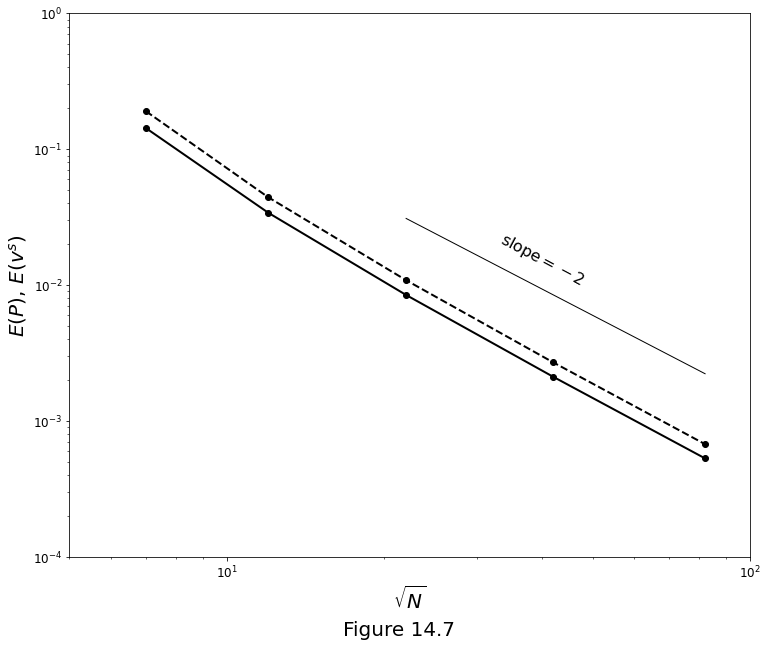

In [16]:
# plotting
f, ax = plt.subplots()
f.set_size_inches(9., 9.)

ax.loglog(
    par.ni, ev, '-ok', linewidth=2, label='velocity'
)
ax.loglog(
    par.ni, ep,'--ok', linewidth=2, label='pressure'
)
ax.loglog(
    par.ni[2:], 15./np.power(par.ni[2:], 2), '-k', linewidth=1
)
ax.set_xlabel(r'$\sqrt{N}$', fontsize=20)
ax.set_ylabel(r'$E(P),\,E(v^s)$', fontsize=20)
ax.text(
    40.0, 0.01, 'slope$=-2$', fontsize=16, 
    rotation=-28, horizontalalignment='center'
)
ax.set_xlim(5.0, 100.0)
ax.set_ylim(1.e-4, 1.0)
ax.tick_params(axis='both', which='major', labelsize=13)
f.supxlabel("Figure 14.7", fontsize=20)
plt.show()